<a href="https://colab.research.google.com/github/mohdtanweer/TensorFlowSpecialisation/blob/master/Sequence_Timeseries_And_Prediction/Week4/sunspots%2Blstm%2Bcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-06-09 10:50:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-06-09 10:50:23 (149 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



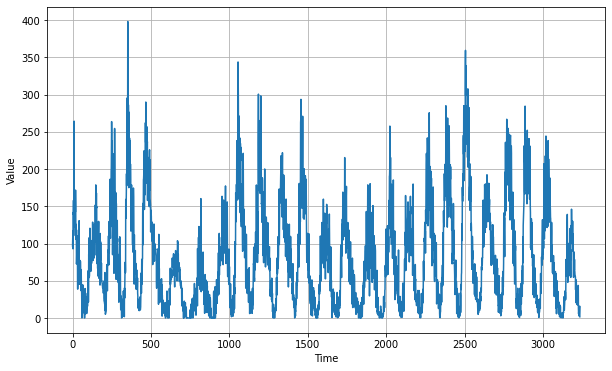

In [6]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

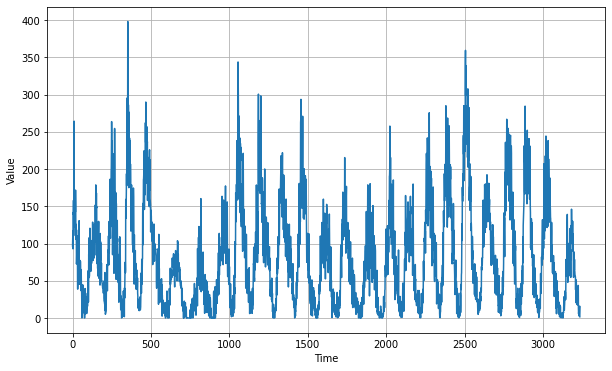

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 26ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 26ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 29ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 25ms/step - loss: 58.1406 - mae: 58.6369 - l

(1e-08, 0.0001, 0.0, 60.0)

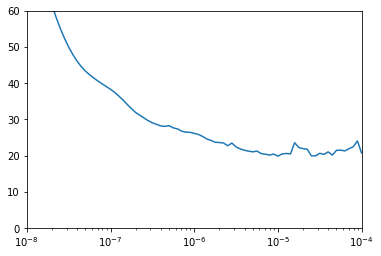

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 14ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 15ms/step - loss: 25.7615 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 22.0742 - mae: 22.5679
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 20.4515 - mae: 20.9443
Epoch 5/500
30/30 [==============================] - 0s 14ms/step - loss: 19.7482 - mae: 20.2407
Epoch 6/500
30/30 [==============================] - 0s 14ms/step - loss: 19.3727 - mae: 19.8649
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 18.5273 - mae: 19.0192
Epoch 8/500
30/30 [==============================] - 0s 15ms/step - loss: 18.3319 - mae: 18.8233
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 17.9902 - mae: 18.4817
Epoch 10/500
30/30 [==============================] - 0s 14ms/step - loss: 17.8811 - mae: 18.3723
Epoch 11/500
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

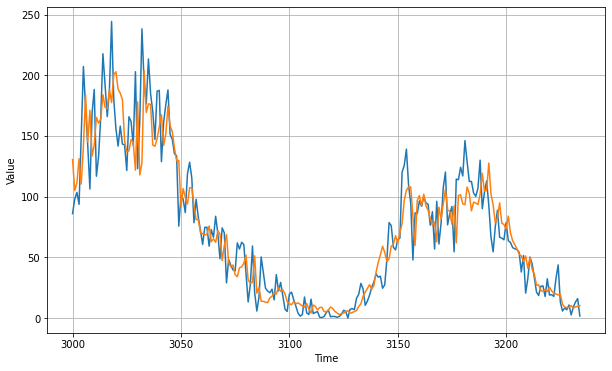

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.330316

<Figure size 432x288 with 0 Axes>

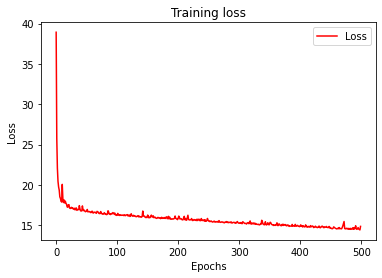

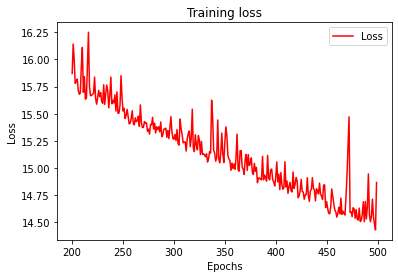

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
print(rnn_forecast)